In [1]:
# import libraries needed
import time
import networkx as nx
from sortedcontainers import SortedList, SortedSet, SortedDict
import random
import numpy as np
import math
from itertools import chain, combinations
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.algorithms.matching import max_weight_matching
from subprocess import check_output
from gurobipy.gurobipy import Model, quicksum, GRB
import matplotlib.pylab as plt


In [2]:
# Create new edge and set edge weight and cost
def setEdgeData(G, edge, weight, cost):
    G.add_edge(edge[0], edge[1])
    G[edge[0]][edge[1]]['weight'] = weight
    G[edge[0]][edge[1]]['cost'] = cost

def getEdgeCost(G, edge):
    return G[edge[0]][edge[1]]['cost']

def getEdgeWeight(G, edge):
    return G[edge[0]][edge[1]]['weight']

def zerotruncatedPoisson(p):
    #source: https://web.archive.org/web/20180826164029/http://giocc.com/zero_truncated_poisson_sampling_algorithm.html
    k = 1
    t = math.e**(-p) / (1 - math.e**(-p)) * p
    s = t
    u = random.random()
    while s < u:
        k += 1
        t *= p / k
        s += t
    return k

def isMatching(edges):
    # Check if set of edges is matching
    seen = []
    for e in edges:
        if e[0] in seen:
            return False
        seen.append(e[0])
        if e[1] in seen:
            return False
        seen.append(e[1])
    return True

def powerset(iterable, maxSize):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(maxSize+1))
def powersetAll(iterable):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))



def generateRandomGraph(n, p, Ew, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ew: zero truncated poisson weight parameter
    Ec: poisson cost parameter
    """
    graph = erdos_renyi_graph(n,p)
    for edge in graph.edges:
        weight = 0
        cost = 0
        weight = zerotruncatedPoisson(Ew)
        cost = np.random.poisson(Ec)
        setEdgeData(graph, edge, weight, cost)
    return graph
    

def computeCost(g, matching):
    # compute cost of matching
    return sum(getEdgeCost(g, e) for e in matching)
def computeWeight(g, matching):
    # compute weight of matching
    return sum(getEdgeWeight(g, e) for e in matching)
def budgetedMatchingProblemBruteforce(g, B):
    # solve BMP by bruteforce
    maximum = 0
    cost = 0
    matching = None
    for e in powerset(g.edges, len(g.nodes)//2):
        if isMatching(e):
            c = computeCost(g, e)
            m = computeWeight(g, e)
            if c <= B and m > maximum:
                maximum = m
                matching = e
                cost = c
    return cost, maximum, matching

def generateRandomRestricted(n, p, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    The weights of all edges are 1
    The costs are following a poisson parameter
    Here the 'weight' variable of each edge denotes the edge cost not edge weight
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ec: poisson cost parameter
    """
    graph = fast_gnp_random_graph(n,p)
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = np.random.poisson(Ec) # Edge cost!
    return graph

def restrictedToGeneral(G):
    """
    Transform graph instance with weights 1
    to general instance of budgeted matching problem
    """
    graph = nx.Graph()
    for e in G.edges():
        setEdgeData(graph, e, 1, G[e[0]][e[1]]['weight'])
    return graph

In [3]:
def graphToAdjacency(G):
    """
    Returns adjacency list from graph
    """
    lines = []
    lines.append(str(len(G.nodes)))
    lines.append(str(len(G.edges)))
    for e in G.edges:
        e0 = e[0]
        e1 = e[1]
        lines.append(f"{e0} {e1} {G[e0][e1]['weight']}")
    return lines


def min_cost_matching(G):
    """
    Returns minimum cost perfect matching, if exists else false
    """
    adjacency = graphToAdjacency(G)
    f = open("input.txt", "w")
    for line in adjacency:
        f.write(line)
        f.write("\n")
    f.close()
    try:
        raw_data = check_output('MinimumCostMatching\example -f input.txt --minweight', shell=True).decode('utf-8').split(":")[-1].split("\r\n")
    except:
        return False
    return set(tuple(int(e) for e in x.split(" ")) for x in raw_data if x!="")

def min_cost_matching_size_k(G, k):
    """
    Compute minimum cost matching of size k
    """
    graph = transform_graph_min_size_k(G, k)
    matching = min_cost_matching(graph)
    if matching == False: return False
    nodesG = len(G.nodes)
    return set(x for x in matching if (x[0] < nodesG and x[1] < nodesG))

def maxweight_to_min_weight(G):
    """
    Transform a max weight problem to min weight problem
    while making sure all edge weights are non-negative
    """
    if len(G.edges) == 0:
        return G.copy()
    maxWeight = max(G[edge[0]][edge[1]]['weight'] for edge in G.edges)
    graph = G.copy()
    for edge in G.edges:
        graph[edge[0]][edge[1]]['weight'] = maxWeight - G[edge[0]][edge[1]]['weight']
    return graph

def transform_graph_min_size_k(G, k, weight="weight"):
    """
    Transforms max weight matching to max weight matching on k vertices
    """
    transG = nx.Graph()
    G_edges = G.edges(data=weight, default=1)
    edges = ((u, v, w) for u, v, w in G_edges)
    transG.add_weighted_edges_from(edges, weight=weight)
    old_nodes = list(G.nodes).copy()
    for i in range(len(G.nodes), 2*len(G.nodes)-2*k):
        for j in old_nodes:
            transG.add_edge(j, i, weight=0)
    return transG

In [4]:
def solve_fcbmp(G, B):
    """
    Solve the budgeted amtching problem with fixed cost constraint in polynomial time
    """
    graph = maxweight_to_min_weight(G)
    maxWeight = 0
    budget = 0
    for i in range(1, min(B, len(G.nodes)//2) + 1):
        matching = min_cost_matching_size_k(graph, i)
        weight = 0
        if matching:
            weight = sum(G[edge[0]][edge[1]]['weight'] for edge in matching)
        if weight > maxWeight:
            maxWeight = weight
            budget = i
    return (maxWeight, budget)

In [5]:
G = generateRandomRestricted(100, 0.8, 1)

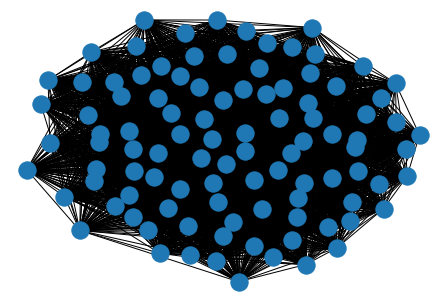

In [6]:
nx.draw(G)

In [7]:
solve_fcbmp(G, 12)

(60, 12)

In [10]:
# ============================================ GUROBI ====================================================
def restricted_graph_to_gurobi(graph, budget):
    # instance of BMP with fixed cost to gurobi instance
    model = Model("Budgeted Matching Restricted")
    x = {}
    edges = list(graph.edges)
    nodes = list(graph.nodes)
    for e in edges:
        x[e] = model.addVar(vtype=GRB.INTEGER, name=f'edge[{e}]', lb = 0, ub=1)
    model.addConstrs(
        (quicksum(x[e] for e in edges if v in e) <= 1 for v in nodes),
        name='Satisfy Matching'
    )
    model.addConstr(
        quicksum(x[e] for e in edges) <= budget,
        name='Satisfy Budget'
    )
    model.setObjective(
        quicksum(x[e] * getEdgeWeight(graph, e) for e in edges),
        sense=GRB.MAXIMIZE
    )
    return model

In [11]:
restricted_graph_to_gurobi(G, 12).optimize()

Using license file c:\gurobi912\gurobi.lic
Set parameter TokenServer to value TUELICENSE4.campus.tue.nl
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 4006 columns and 12018 nonzeros
Model fingerprint: 0xbb1e71e0
Variable types: 0 continuous, 4006 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 19.0000000
Presolve removed 0 rows and 1449 columns
Presolve time: 0.03s
Presolved: 101 rows, 2557 columns, 7671 nonzeros
Variable types: 0 continuous, 2557 integer (2557 binary)

Root relaxation: objective 6.000000e+01, 98 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0      

In [ ]:
'''
Test of budgeted matching with fixed cost on dense graphs
Results get saved in dict times_brute_dense and times_gurobi_dense
'''
# Dense Graphs
times_brute_dense = {}
times_gurobi_dense = {}
for n in range(0, 1001, 50):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(1):
        g = generateRandomRestricted(n, 0.8, 10)
        gurobi = restricted_graph_to_gurobi(g, n//4)
        start = time.time()
        solve_fcbmp(g, n//4)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute_dense[n] = running_time_bruteforce / 1
    times_gurobi_dense[n] = running_time_gurobi / 1

iterationnumber 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Model fingerprint: 0x0268838a
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
iterationnumber 50
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 51 rows, 976 columns and 2928 nonzeros
Model fingerprint: 0x059ee831
Variable types: 0 continuous, 976 integer (0 binary)
Coeffi

       3       1274   6.9619702e+09  -1.0266321e+04      0s
       4       1742   2.3779874e+09  -6.0343173e+03      0s
       5       2319  -9.7250000e+02  -4.0061978e+03      0s
       6       2924  -1.5410000e+03  -3.0666233e+03      0s
       7       3485  -1.5710000e+03  -1.8697611e+03      0s

Sifting complete


Root relaxation: objective 1.575000e+03, 3986 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1575.0000000 1575.00000  0.00%     -    0s

Explored 0 nodes (3986 simplex iterations) in 0.24 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 1575 750 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.575000000000e+03, best bound 1.575000000000e+03, gap 0.0000%
iterationnumber 350
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical pro


Optimal solution found (tolerance 1.00e-04)
Best objective 2.683000000000e+03, best bound 2.683000000000e+03, gap 0.0000%
iterationnumber 550
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 551 rows, 120662 columns and 361986 nonzeros
Model fingerprint: 0x334e3859
Variable types: 0 continuous, 120662 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 1367.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.34s
Presolved: 551 rows, 120654 columns, 361962 nonzeros
Variable types: 0 continuous, 120654 integer (120654 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -1.7408300e+05      0s
       1 


Optimal solution found (tolerance 1.00e-04)
Best objective 3.876000000000e+03, best bound 3.876000000000e+03, gap 0.0000%
iterationnumber 750
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 751 rows, 224787 columns and 674361 nonzeros
Model fingerprint: 0x0f410847
Variable types: 0 continuous, 224787 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 1880.0000000
Presolve removed 0 rows and 7 columns
Presolve time: 0.90s
Presolved: 751 rows, 224780 columns, 674340 nonzeros
Variable types: 0 continuous, 224780 integer (224780 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -3.0323300e+05      1s
       1 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5032.0000000 5032.00000  0.00%     -    2s

Explored 0 nodes (19354 simplex iterations) in 2.39 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 5032 2206 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.032000000000e+03, best bound 5.032000000000e+03, gap 0.0000%
iterationnumber 950


In [ ]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute_dense.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi_dense.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['BMP with fixed cost constraint solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of BMP with fixed cost constraint solver on dense graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

In [50]:
'''
Test of budgeted matching with fixed cost on sparse graphs
Results get saved in dict times_brute and times_gurobi
'''
# Sparse Graphs
times_brute = {}
times_gurobi = {}
for n in range(0, 1001, 20):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 2 / n, 10)
        gurobi = restricted_graph_to_gurobi(g, n//4)
        start = time.time()
        solve_fcbmp(g, n//4)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute[n] = running_time_bruteforce / 5
    times_gurobi[n] = running_time_gurobi / 5

iterationnumber 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Model fingerprint: 0x772aff6c
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to

Found heuristic solution: objective -0.0000000
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
iterationnumber 3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x0b94b609
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolve: All r

Model fingerprint: 0x5dbfb4ca
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
iterationnumber 4
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5 rows, 3 columns and 9 nonzeros
Model fingerprint: 0x97bf7433
Variable types: 0 continuous, 3 integer (0 binary)
Coefficient statistics:
  Matrix range  

Optimize a model with 5 rows, 5 columns and 15 nonzeros
Model fingerprint: 0xfb480dd4
Variable types: 0 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 14 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+01, best bound 1.400000000000e+01, gap 0.0000%
iterationnumber 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 6 rows, 5 columns and 15 nonzeros
Model fingerprint: 0xf252e9ab
Variable types: 0 continuous, 5 integer (0 binary)
Coefficient stat

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 6 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x623a7042
Variable types: 0 continuous, 4 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 11.0000000
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 16 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.600000000000e+01, best bound 1.600000000000e+01, gap 0.0000%
iterationnumber 6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7 rows, 5 columns and 15 nonzeros
Model fingerprint: 

Optimize a model with 7 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x335ed0e7
Variable types: 0 continuous, 4 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.0000000
Presolve removed 7 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 13 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
iterationnumber 7
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8 rows, 1 columns and 3 nonzeros
Model fingerprint: 0x14f48271
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statist

Model fingerprint: 0x1e22dd83
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 14.0000000
Presolve removed 8 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 15 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
iterationnumber 8
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 9 rows, 7 columns and 21 nonzeros
Model fingerprint: 0xa9bcd26b
Variable types: 0 continuous, 7 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective ra

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 18.0000000
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 24.0000000
Variable types: 0 continuous, 6 integer (6 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 24 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x55783733
Variable types: 0 continuous, 4 integer (0 binary)
Coefficient stat

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 23.0000000
Presolve removed 10 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 10 rows, 5 columns and 15 nonzeros
Model fingerprint: 0x60154aa7
Variable types: 0 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuris

  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 11 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 22 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.200000000000e+01, best bound 2.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 11 columns and 33 nonzeros
Model fingerprint: 0x8fab6813
Variable types: 0 continuous, 11 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolved: 8 rows, 8 column

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 6 rows and 0 columns
Presolve time: 0.00s
Presolved: 6 rows, 7 columns, 18 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)

Root relaxation: objective 2.800000e+01, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      28.0000000   28.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 28 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 12 rows, 9 columns and 27 n


Solution count 3: 25 23 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 12 rows, 14 columns and 42 nonzeros
Model fingerprint: 0xcd40a450
Variable types: 0 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolved: 10 rows, 12 columns, 35 nonzeros
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 3.100000e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 22.0000000
Presolve time: 0.00s
Presolved: 13 rows, 16 columns, 48 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 4.700000e+01, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      47.0000000   47.00000  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 47 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.700000000000e+01, best bound 4.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 13 rows, 11 columns and 33 nonzeros
Model fingerprint: 0x6d979d41
Variable types: 0 continuous,

  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 35.0000000
Presolve removed 6 rows and 1 columns
Presolve time: 0.00s
Presolved: 8 rows, 11 columns, 31 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)

Root relaxation: objective 3.900000e+01, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      39.0000000   39.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 39 35 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.900000000000e+01, best bound 3.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 14 rows, 14 columns and 42 nonzeros
Model fingerprint: 0x7

Variable types: 0 continuous, 12 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 28.0000000
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 21 nonzeros
Variable types: 0 continuous, 8 integer (8 binary)

Root relaxation: objective 3.500000e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      35.0000000   35.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 35 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.500000000000e+01, best bound 3.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v

  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 36.0000000
Presolve removed 7 rows and 7 columns
Presolve time: 0.00s
Presolved: 8 rows, 10 columns, 25 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: objective 4.300000e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      43.0000000   43.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 43 36 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.300000000000e+01, best bound 4.300000000000e+01, gap 0.0000%
iterationnumber 15
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 t

Presolve time: 0.00s
Presolved: 8 rows, 11 columns, 29 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)

Root relaxation: objective 4.300000e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      43.0000000   43.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 43 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.300000000000e+01, best bound 4.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 16 rows, 16 columns and 48 nonzeros
Model fingerprint: 0xf9d8bf2b
Variable types: 0 continuous, 16 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
 

Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 42 39 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.200000000000e+01, best bound 4.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17 rows, 12 columns and 36 nonzeros
Model fingerprint: 0xfa79b16a
Variable types: 0 continuous, 12 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 34.0000000
Presolve removed 17 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)



Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 18 rows, 10 columns and 30 nonzeros
Model fingerprint: 0xe75ddd78
Variable types: 0 continuous, 10 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 19 nonzeros
Found heuristic solution: objective 52.0000000
Variable types: 0 continuous, 8 integer (8 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        52.00000   52.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations)

Presolve removed 18 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 62 56 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.200000000000e+01, best bound 6.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 18 rows, 15 columns and 45 nonzeros
Model fingerprint: 0xf155426c
Variable types: 0 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 8 rows and 2 columns
Presolve time: 0.00s
Presolved: 10 rows, 13 columns, 34 nonzeros
Variable types: 0 continuous, 13 integer (13 binary)

Root rela


*    0     0               0      56.0000000   56.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 56 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.600000000000e+01, best bound 5.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 19 rows, 14 columns and 42 nonzeros
Model fingerprint: 0x7e523aa2
Variable types: 0 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 38.0000000
Presolve removed 16 rows and 8 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros
Found heuristic solution: objective 60.0000000
Variable types: 0 continuous, 6 integer 

Presolve removed 9 rows and 5 columns
Presolve time: 0.00s
Presolved: 11 rows, 16 columns, 41 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 5.900000e+01, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      59.0000000   59.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 59 42 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.900000000000e+01, best bound 5.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20 rows, 16 columns and 48 nonzeros
Model fingerprint: 0xaaa0fa72
Variable types: 0 continuous, 16 integer (0 binary)
Coefficient statisti

Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective 6.100000e+01, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      61.0000000   61.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 61 58 53 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.100000000000e+01, best bound 6.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 19 columns and 57 nonzeros
Model fingerprint: 0xeacd65cf
Variable types: 0 continuous, 19 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1


Root relaxation: objective 7.500000e+01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      75.0000000   75.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 75 69 50 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.500000000000e+01, best bound 7.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 19 columns and 57 nonzeros
Model fingerprint: 0x4a5108f3
Variable types: 0 continuous, 19 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heurist


Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 66 58 47 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.600000000000e+01, best bound 6.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 22 rows, 26 columns and 78 nonzeros
Model fingerprint: 0xe1fb44f0
Variable types: 0 continuous, 26 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 54.0000000
Presolve removed 10 rows and 9 columns
Presolve time: 0.00s
Presolved: 12 rows, 17 columns, 42 nonzeros
Found heuristic solution: objective 66.0000000
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    


Solution count 2: 57 44 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.700000000000e+01, best bound 5.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 16 columns and 48 nonzeros
Model fingerprint: 0x529b3bee
Variable types: 0 continuous, 16 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 42.0000000
Presolve removed 17 rows and 6 columns
Presolve time: 0.00s
Presolved: 6 rows, 10 columns, 21 nonzeros
Found heuristic solution: objective 66.0000000
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 55.0000000
Presolve removed 10 rows and 7 columns
Presolve time: 0.00s
Presolved: 13 rows, 19 columns, 51 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)

Root relaxation: objective 7.000000e+01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      70.0000000   70.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 70 55 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+01, best bound 7.000000000000e+01, gap 0.0000%
iterationnumber 23
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 24 rows, 22 columns and 66 nonzeros
Model fingerprint: 0x32460ff2
Variable types: 0 continuous, 22 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 47.0000000
Presolve removed 21 rows and 16 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros
Found heuristic solution: objective 61.0000000
Variable types: 0 continuous, 6 integer (4 binary)

Root relaxation: objective 6.600000e+01, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      66.0000000   66.00000  0.00%     -    0s

Explored 0 nodes (1 si

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 25 rows, 27 columns and 81 nonzeros
Model fingerprint: 0xe7c9f2ca
Variable types: 0 continuous, 27 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 53.0000000
Presolve removed 10 rows and 5 columns
Presolve time: 0.00s
Presolved: 15 rows, 22 columns, 59 nonzeros
Found heuristic solution: objective 64.0000000
Variable types: 0 continuous, 22 integer (22 binary)

Root relaxation: objective 6.600000e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      66.0000000   66.00000  0.00%     -    0s

Explored 0 nodes (6

  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 18 rows and 11 columns
Presolve time: 0.00s
Presolved: 8 rows, 13 columns, 29 nonzeros
Found heuristic solution: objective 84.0000000
Variable types: 0 continuous, 13 integer (13 binary)

Root relaxation: cutoff, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        84.00000   84.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 84 45 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.400000000000e+01, best bound 8.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, us


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      73.0000000   73.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 73 58 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.300000000000e+01, best bound 7.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 26 rows, 32 columns and 96 nonzeros
Model fingerprint: 0x38505042
Variable types: 0 continuous, 32 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 54.0000000
Presolve removed 7 rows and 3 columns


Found heuristic solution: objective 94.0000000
Variable types: 0 continuous, 29 integer (28 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        94.00000   94.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 94 45 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.400000000000e+01, best bound 9.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 27 rows, 29 columns and 87 nonzeros
Model fingerprint: 0xdd8f89f4
Variable types: 0 continuous, 29 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]


Variable types: 0 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 49.0000000
Presolve removed 28 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 77 49 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.700000000000e+01, best bound 7.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 28 rows, 16 columns and 48 nonzeros
Model fingerprint: 0xfd8c7789
Variable types: 0 continuous, 16 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      84.0000000   84.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 84 80 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.400000000000e+01, best bound 8.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 28 rows, 20 columns and 60 nonzeros
Model fingerprint: 0xeba3108f
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 75.0000000
Presolve removed 16 rows and 3 columns


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      89.0000000   89.00000  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 89 88 65 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.900000000000e+01, best bound 8.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 29 rows, 31 columns and 93 nonzeros
Model fingerprint: 0x692ec7dc
Variable types: 0 continuous, 31 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 81.0000000
Presolve removed 17 rows and 11 co

Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: objective 9.600000e+01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      96.0000000   96.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 96 76 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.600000000000e+01, best bound 9.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 30 rows, 21 columns and 63 nonzeros
Model fingerprint: 0x92902877
Variable types: 0 continuous, 21 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+0

Variable types: 0 continuous, 27 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 77.0000000
Presolve removed 27 rows and 22 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros
Found heuristic solution: objective 94.0000000
Variable types: 0 continuous, 5 integer (3 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 94 77 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.400000000000e+01, best bound 9.400000000000e+01, gap 0.0000%
iterationnumber 30
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 31 rows, 25 columns and 75 nonzeros
Model fingerprint: 0xf5

Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 106 70 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.060000000000e+02, best bound 1.060000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 31 rows, 26 columns and 78 nonzeros
Model fingerprint: 0x2c44c076
Variable types: 0 continuous, 26 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 70.0000000
Presolve removed 19 rows and 5 columns
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 52 nonzeros
Found heuristic solution: objective 80.0000000
Variable types: 0 continuous, 21 integer (21 binary)



Found heuristic solution: objective 66.0000000
Presolve removed 24 rows and 7 columns
Presolve time: 0.00s
Presolved: 8 rows, 15 columns, 31 nonzeros
Found heuristic solution: objective 94.0000000
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective 9.700000e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      97.0000000   97.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 97 94 66 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.700000000000e+01, best bound 9.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 32 rows, 29 columns and 87 nonzeros
Model

iterationnumber 32
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 33 rows, 30 columns and 90 nonzeros
Model fingerprint: 0x97943278
Variable types: 0 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 73.0000000
Presolve removed 21 rows and 9 columns
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 47 nonzeros
Found heuristic solution: objective 120.0000000
Variable types: 0 continuous, 21 integer (21 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       120.00000  120.00000  0.00%     -    0s

Explored 0 node

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 33 rows, 31 columns and 93 nonzeros
Model fingerprint: 0x34b5a29d
Variable types: 0 continuous, 31 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 78.0000000
Presolve removed 28 rows and 19 columns
Presolve time: 0.00s
Presolved: 5 rows, 12 columns, 20 nonzeros
Found heuristic solution: objective 93.0000000
Variable types: 0 continuous, 12 integer (11 binary)

Root relaxation: objective 1.040000e+02, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     104.0000000  104.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 1

Best objective 1.080000000000e+02, best bound 1.080000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 34 rows, 38 columns and 114 nonzeros
Model fingerprint: 0x91e64171
Variable types: 0 continuous, 38 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 76.0000000
Presolve removed 14 rows and 10 columns
Presolve time: 0.00s
Presolved: 20 rows, 28 columns, 73 nonzeros
Found heuristic solution: objective 110.0000000
Variable types: 0 continuous, 28 integer (28 binary)

Root relaxation: objective 1.120000e+02, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0  


Root relaxation: objective 1.110000e+02, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     111.0000000  111.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 111 103 84 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.110000000000e+02, best bound 1.110000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 35 rows, 30 columns and 90 nonzeros
Model fingerprint: 0x5f81980a
Variable types: 0 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuri

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 88.0000000
Presolve removed 17 rows and 7 columns
Presolve time: 0.00s
Presolved: 18 rows, 26 columns, 68 nonzeros
Variable types: 0 continuous, 26 integer (25 binary)

Root relaxation: objective 1.080000e+02, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     108.0000000  108.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 108 88 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.080000000000e+02, best bound 1.080000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical core

Best objective 1.220000000000e+02, best bound 1.220000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 36 rows, 30 columns and 90 nonzeros
Model fingerprint: 0x5e9f158f
Variable types: 0 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 77.0000000
Presolve removed 25 rows and 10 columns
Presolve time: 0.00s
Presolved: 11 rows, 20 columns, 42 nonzeros
Found heuristic solution: objective 107.0000000
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 1.160000e+02, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0   


*    0     0               0     102.0000000  102.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 102 100 92 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.020000000000e+02, best bound 1.020000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 37 rows, 28 columns and 84 nonzeros
Model fingerprint: 0x3ee8eb0c
Variable types: 0 continuous, 28 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 93.0000000
Presolve removed 30 rows and 13 columns
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 27 nonzeros
Found heuristic solution: objective 106.0000000
Variable types: 0 continuous, 15

Found heuristic solution: objective 81.0000000
Presolve removed 18 rows and 7 columns
Presolve time: 0.00s
Presolved: 19 rows, 25 columns, 65 nonzeros
Variable types: 0 continuous, 25 integer (25 binary)

Root relaxation: objective 1.090000e+02, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     109.0000000  109.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 109 81 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.090000000000e+02, best bound 1.090000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 37 rows, 39 columns and 117 nonzeros
Model fingerprint: 0xde5ab938
Variable types: 0 cont

  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 115.0000000
Presolve removed 25 rows and 11 columns
Presolve time: 0.00s
Presolved: 13 rows, 20 columns, 45 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 1.250000e+02, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     125.0000000  125.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 125 115 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250000000000e+02, best bound 1.250000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 38 rows, 26 columns and 78 nonzeros
Model fingerprin

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 39 rows, 32 columns and 96 nonzeros
Model fingerprint: 0xe6e65df4
Variable types: 0 continuous, 32 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 83.0000000
Presolve removed 33 rows and 18 columns
Presolve time: 0.00s
Presolved: 6 rows, 14 columns, 26 nonzeros
Found heuristic solution: objective 101.0000000
Variable types: 0 continuous, 14 integer (13 binary)

Root relaxation: objective 1.100000e+02, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     110.0000000  110.00000  0.00%     -    0s

Explored 0 nodes (


*    0     0               0     123.0000000  123.00000  0.00%     -    0s

Explored 0 nodes (12 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 123 91 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.230000000000e+02, best bound 1.230000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 39 rows, 32 columns and 96 nonzeros
Model fingerprint: 0xe45253e3
Variable types: 0 continuous, 32 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 94.0000000
Presolve removed 25 rows and 8 columns
Presolve time: 0.00s
Presolved: 14 rows, 24 columns, 56 nonzeros
Found heuristic solution: objective 107.0000000
Variable types: 0 continuous, 24 in


*    0     0               0     115.0000000  115.00000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 115 108 72 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.150000000000e+02, best bound 1.150000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 40 rows, 35 columns and 105 nonzeros
Model fingerprint: 0x981c2ca2
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 91.0000000
Presolve removed 29 rows and 16 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 40 nonzeros
Found heuristic solution: objective 105.0000000
Variable types: 0 continuous, 

Presolve removed 29 rows and 22 columns
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 46 nonzeros
Found heuristic solution: objective 122.0000000
Variable types: 0 continuous, 21 integer (19 binary)

Root relaxation: objective 1.310000e+02, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     131.0000000  131.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 131 122 101 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.310000000000e+02, best bound 1.310000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41 rows, 32 columns and 96 nonzeros
Model fingerprint: 0x4fc15982
Variable types: 

Optimize a model with 41 rows, 41 columns and 123 nonzeros
Model fingerprint: 0x2f0e235d
Variable types: 0 continuous, 41 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 103.0000000
Presolve removed 28 rows and 17 columns
Presolve time: 0.00s
Presolved: 13 rows, 24 columns, 56 nonzeros
Found heuristic solution: objective 118.0000000
Variable types: 0 continuous, 24 integer (21 binary)

Root relaxation: objective 1.320000e+02, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     132.0000000  132.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 132 118 103 

Optimal so

Optimize a model with 42 rows, 38 columns and 114 nonzeros
Model fingerprint: 0x5a285556
Variable types: 0 continuous, 38 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 106.0000000
Presolve removed 34 rows and 20 columns
Presolve time: 0.00s
Presolved: 8 rows, 18 columns, 33 nonzeros
Found heuristic solution: objective 133.0000000
Variable types: 0 continuous, 18 integer (17 binary)

Root relaxation: objective 1.380000e+02, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     138.0000000  138.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 138 133 106 

Optimal sol


Explored 0 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 141 97 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.410000000000e+02, best bound 1.410000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 43 rows, 35 columns and 105 nonzeros
Model fingerprint: 0x85e26bb0
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 93.0000000
Presolve removed 28 rows and 12 columns
Presolve time: 0.00s
Presolved: 15 rows, 23 columns, 55 nonzeros
Found heuristic solution: objective 129.0000000
Variable types: 0 continuous, 23 integer (22 binary)

Root relaxation: objective 1.340000e+02, 7 iterations, 

Presolve time: 0.00s
Presolved: 22 rows, 32 columns, 81 nonzeros
Found heuristic solution: objective 120.0000000
Variable types: 0 continuous, 32 integer (31 binary)

Root relaxation: objective 1.370000e+02, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     137.0000000  137.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 137 120 79 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.370000000000e+02, best bound 1.370000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 43 rows, 31 columns and 93 nonzeros
Model fingerprint: 0xa8c6bb47
Variable types: 0 continuous, 31 integer (0 binary)
Coeff

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 44 rows, 33 columns and 99 nonzeros
Model fingerprint: 0x9c739967
Variable types: 0 continuous, 33 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 91.0000000
Presolve removed 35 rows and 15 columns
Presolve time: 0.00s
Presolved: 9 rows, 18 columns, 34 nonzeros
Found heuristic solution: objective 111.0000000
Variable types: 0 continuous, 18 integer (16 binary)

Root relaxation: objective 1.290000e+02, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     129.0000000  129.00000  0.00%     -    0s

Explored 0 nodes (


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     152.0000000  152.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 152 135 121 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.520000000000e+02, best bound 1.520000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 45 rows, 40 columns and 120 nonzeros
Model fingerprint: 0x6dba6ade
Variable types: 0 continuous, 40 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 117.0000000
Presolve removed 42 rows and 3

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 116.0000000
Presolve removed 27 rows and 11 columns
Presolve time: 0.00s
Presolved: 18 rows, 28 columns, 66 nonzeros
Found heuristic solution: objective 140.0000000
Variable types: 0 continuous, 28 integer (27 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       140.00000  140.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 140 116 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+02, best bound 1.400000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (w

Thread count was 12 (of 12 available processors)

Solution count 3: 141 133 91 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.410000000000e+02, best bound 1.410000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 46 rows, 45 columns and 135 nonzeros
Model fingerprint: 0xb7cecabf
Variable types: 0 continuous, 45 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 113.0000000
Presolve removed 39 rows and 29 columns
Presolve time: 0.00s
Presolved: 7 rows, 16 columns, 29 nonzeros
Found heuristic solution: objective 150.0000000
Variable types: 0 continuous, 16 integer (14 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds

Found heuristic solution: objective 138.0000000
Variable types: 0 continuous, 29 integer (29 binary)

Root relaxation: objective 1.400000e+02, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     140.0000000  140.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 140 138 119 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+02, best bound 1.400000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 47 rows, 39 columns and 117 nonzeros
Model fingerprint: 0x10df749e
Variable types: 0 continuous, 39 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objectiv

Optimize a model with 47 rows, 47 columns and 141 nonzeros
Model fingerprint: 0x565742ba
Variable types: 0 continuous, 47 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 102.0000000
Presolve removed 21 rows and 5 columns
Presolve time: 0.00s
Presolved: 26 rows, 42 columns, 114 nonzeros
Variable types: 0 continuous, 42 integer (42 binary)

Root relaxation: objective 1.470000e+02, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     147.0000000  147.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 147 102 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.4


*    0     0               0     150.0000000  150.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 150 145 112 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+02, best bound 1.500000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 48 rows, 46 columns and 138 nonzeros
Model fingerprint: 0xdeb7446e
Variable types: 0 continuous, 46 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 105.0000000
Presolve removed 34 rows and 25 columns
Presolve time: 0.00s
Presolved: 14 rows, 21 columns, 49 nonzeros
Found heuristic solution: objective 125.0000000
Variable types: 0 continuous

Found heuristic solution: objective 121.0000000
Presolve removed 25 rows and 15 columns
Presolve time: 0.00s
Presolved: 24 rows, 36 columns, 91 nonzeros
Found heuristic solution: objective 149.0000000
Variable types: 0 continuous, 36 integer (36 binary)

Root relaxation: objective 1.520000e+02, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     152.0000000  152.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 152 149 121 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.520000000000e+02, best bound 1.520000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 49 rows, 44 columns and 132 nonzer

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 49 rows, 51 columns and 153 nonzeros
Model fingerprint: 0x19ee7281
Variable types: 0 continuous, 51 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 115.0000000
Presolve removed 41 rows and 35 columns
Presolve time: 0.00s
Presolved: 8 rows, 16 columns, 30 nonzeros
Found heuristic solution: objective 140.0000000
Variable types: 0 continuous, 16 integer (12 binary)

Root relaxation: objective 1.500000e+02, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     150.0000000  150.00000  0.00%     -    0s

Explored 0 nodes

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     160.0000000  160.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 160 158 105 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.600000000000e+02, best bound 1.600000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 50 rows, 40 columns and 120 nonzeros
Model fingerprint: 0x6189c2bd
Variable types: 0 continuous, 40 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 126.0000000
Presolve removed 36 rows and 16 columns
Presolve time: 0.00s
Presolved: 14 rows, 24 columns, 53 nonzeros

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 134.0000000
Presolve removed 31 rows and 13 columns
Presolve time: 0.00s
Presolved: 20 rows, 30 columns, 72 nonzeros
Found heuristic solution: objective 159.0000000
Variable types: 0 continuous, 30 integer (29 binary)

Root relaxation: objective 1.660000e+02, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     166.0000000  166.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 166 159 134 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.660000000000e+02, best bound 1.660000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to

  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 127.0000000
Presolve removed 28 rows and 8 columns
Presolve time: 0.00s
Presolved: 23 rows, 31 columns, 82 nonzeros
Variable types: 0 continuous, 31 integer (30 binary)

Root relaxation: objective 1.540000e+02, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     154.0000000  154.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 154 127 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.540000000000e+02, best bound 1.540000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimiz

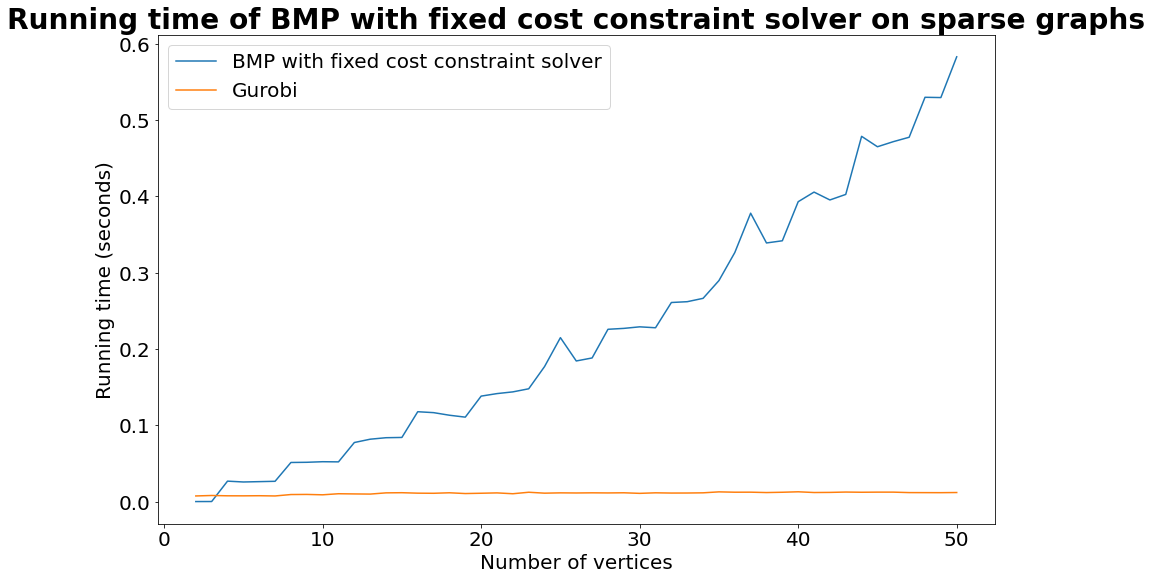

In [51]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['BMP with fixed cost constraint solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of BMP with fixed cost constraint solver on sparse graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()